In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
from xgboost import plot_importance
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
njobs = 4
randomState = 0

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load preprocessed data
X_train = pd.read_csv("cleanData/X_train.csv")
X_test = pd.read_csv("cleanData/X_test.csv")
y_train = pd.read_csv("cleanData/y_train.csv", header = None)
testIDs = pd.read_csv("cleanData/testIDs.csv", header = None)
y_train = y_train[0]
testIDs = testIDs[0]

In [3]:
# Define error measure for official scoring : RMSE
#def rmse(y_train, y_train_pred):
#    return(np.sqrt(mean_squared_error(y_train, y_train_pred)))

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

RMSE on Training set : 0.113366490669


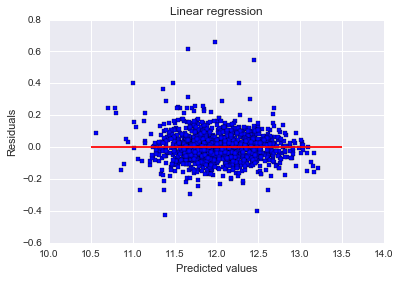

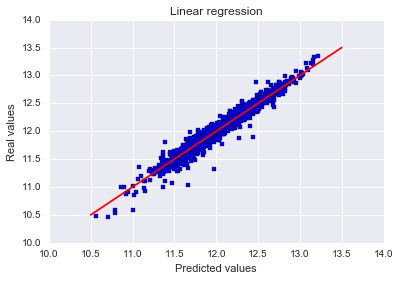

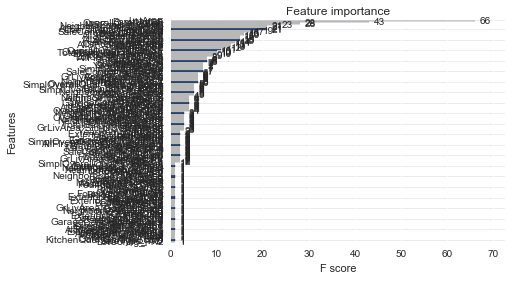

In [4]:
# xgboost
xgboost = xgb.XGBRegressor(nthread = njobs, 
                           n_estimators = 375, 
                           max_depth = 2, 
                           learning_rate = 0.05, 
                           gamma = 0.002, 
                           min_child_weight = 2, 
                           subsample = 0.70, 
                           colsample_bytree = 0.5, 
                           colsample_bylevel = 0.7, 
                           reg_alpha = 0.1)
xgboost.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(xgboost).mean())
y_train_pred = xgboost.predict(X_train)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
plot_importance(xgboost)
plt.show()

In [5]:
# Write predictions in CSV file
now = datetime.datetime.now()
xgboost_name = "preds/xgboost_" + str(now.strftime("%Y-%m-%d-%H-%M")) + ".csv"
preds = pd.DataFrame({"id": testIDs, "SalePrice": np.expm1(xgboost.predict(X_test))}, columns = ["id", "SalePrice"])
preds.to_csv(xgboost_name, index = False)